# PLAYGROUND

In [18]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import keras
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from tqdm.auto import tqdm

# helper functions
def train_model(model, x, max_epochs, early_stopping=True, logger_dir='tmp/keras_logs/simple_gan_v1.csv', patience=10000//10):
    reusable_pbar=tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                d_optimizer=keras.optimizers.Adam(0.001),
                g_optimizer=keras.optimizers.Adam(0.0001))
    
    callbacks = [keras.callbacks.CSVLogger(logger_dir),
                 ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='d_loss', mode='min', patience=patience))

    history = model.fit(
        x,
        epochs=max_epochs,
        verbose=0, # type: ignore
        shuffle=True,
        callbacks=callbacks
    )
    return history

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

## GAN

In [ ]:
# parameters
n_features = 10
latent_dim = 64

# data
data = MockTemporalData(n_samples=20, n_features=n_features, n_timepoints=100)
x, _ = data()

# model
model = SimpleGAN(time_dim=100, feature_dim=n_features, latent_dim=latent_dim)
history = train_model(model, x, max_epochs=10000, early_stopping=True)

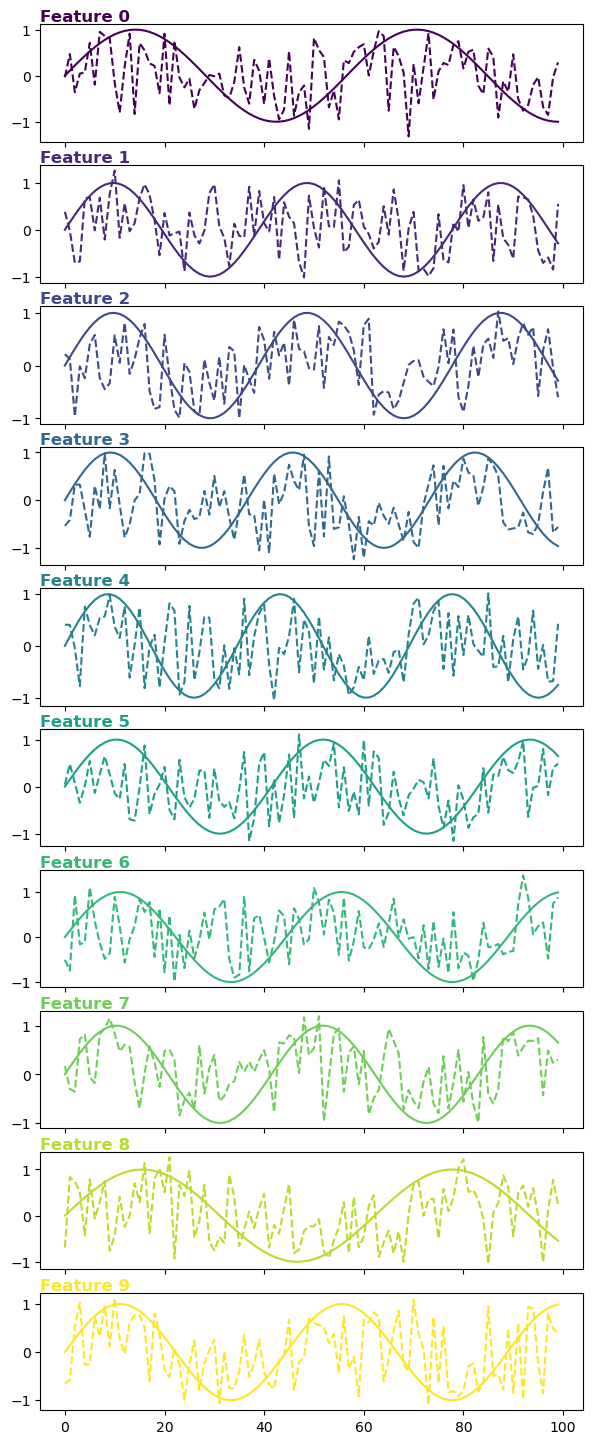

In [40]:
from matplotlib import pyplot as plt
import numpy as np
subject_to_plot = 0
feature_to_plot = range(n_features)
noise = keras.random.normal((1, latent_dim))
x_gen = model.generator(noise)
# pick colors based on the number of features
colors = plt.cm.viridis(np.linspace(0, 1, n_features))
# share x axis

fig, axes = plt.subplots(n_features, 1, figsize=(7, 1.8*n_features), sharex=True)
for i, (c, f) in enumerate(zip(colors, feature_to_plot)):
    axes[i].plot(x[subject_to_plot, :, f], label='real', color=c)
    axes[i].plot(x_gen[subject_to_plot, :, f].cpu().detach().numpy().squeeze(), label='generated', color=c, linestyle='--')
    axes[i].set_title(f'Feature {f}', fontsize=12, fontweight='bold', color=c, loc='left', verticalalignment='top')
plt.show()

## Load model from checkpoints

In [ ]:
from src.EEGModalNet.models import SimpleGAN
model = SimpleGAN(time_dim=100, feature_dim=1, latent_dim=64)
model.load_weights('tmp/keras_models/simple_gan_v1_HPC.model.keras')

## Train with Real Data

### Timeseries

In [ ]:
data = LEMONEEGDataModule(n_subjects=1).prepare_data()
x = data.train_dataset['x'].mean(axis=2)[20:40]
x = x[np.newaxis, 19, :, np.newaxis].repeat(20, axis=0)

model = SimpleGAN(time_dim=128, feature_dim=1, latent_dim=100)
history = train_model(model, x, max_epochs=1000, early_stopping=True, patience=200)

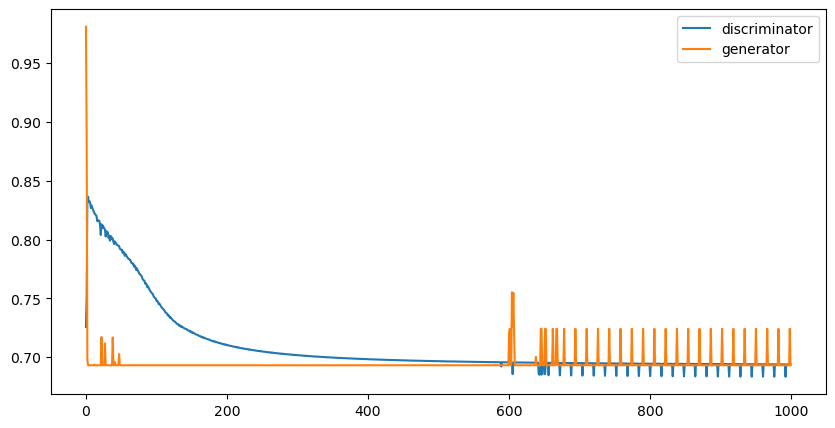

In [14]:
plot_history(history)

In [23]:
from keras import layers
input_layer = keras.Input(shape=(100,))
x = layers.Reshape((1, 100))(input_layer)
x = layers.Conv1D(128, 3, padding='same')(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv1D(256, 3, padding='same')(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv1D(512, 3, padding='same')(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Dense(128 * 1)(x)
x = layers.Reshape((128, 1))(x)

# Residual connections
x = layers.Add()([x, input_layer])

generator = keras.Model(inputs=input_layer, outputs=x, name='generator')

generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_19          │ (None, 1, 100)    │          0 │ input_layer_16[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 1, 128)    │     38,528 │ reshape_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 1, 128)    │          0 │ conv1d_28[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 1, 256)    │     98,560 │ leaky_re_lu_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 1, 256)    │          0 │ conv1d_29[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 1, 512)    │    393,728 │ leaky_re_lu_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_30      │ (None, 1, 512)    │          0 │ conv1d_30[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1, 128)    │     65,664 │ leaky_re_lu_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_20          │ (None, 128, 1)    │          0 │ dense_27[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 100)  │          0 │ reshape_20[0][0], │
│                     │                   │            │ input_layer_16[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 596,480 (2.28 MB)

 Trainable params: 596,480 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

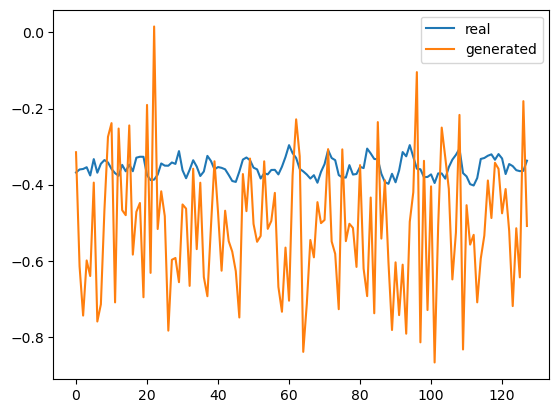

x_gen: tensor([[2.2815e-08]], device='mps:0', grad_fn=<SigmoidBackward0>) 
x: tensor([[2.4916e-06],
        [1.7067e-06],
        [4.6856e-06],
        [3.0696e-06],
        [3.0497e-06],
        [3.9594e-06],
        [4.0675e-06],
        [4.0047e-06],
        [2.3811e-06],
        [2.7084e-06],
        [5.1155e-06],
        [3.3875e-06],
        [3.2467e-06],
        [1.7339e-06],
        [1.4052e-06],
        [2.3473e-06],
        [3.5508e-06],
        [2.2990e-06],
        [3.0505e-06],
        [2.6173e-06]], device='mps:0', grad_fn=<SigmoidBackward0>)


In [61]:
x_gen = model.generator(keras.random.normal((1, 64)))
b_to_plot = 10
plt.plot(x[b_to_plot, :], label='real')
plt.plot(x_gen.cpu().detach().numpy().squeeze(), label='generated')
plt.legend()
plt.show()
print('x_gen:', model.discriminator(x_gen), '\nx:', model.discriminator(x))

It seems that the discriminator does not learn to tell the generated from the real models apart. Also the generated data is similar to noise, and we cannot tell if it has ever learned anything unless we check if they show similar properties such as their mean, variance, power spectrum, etc. Then we switch to using a simpler data, for example the wavelets instead of raw data in the next section.
The second solution might be making the generator more complex, for example by adding more layers, or using a different architecture therefore it could learn the nauances of the data better.

### Wavelets

In [ ]:
# data
wavelets = xr.open_dataarray('data/LEMON_data/wavelets.nc5')
x = wavelets.sel(subject=wavelets.subject[0]).to_numpy()
# x = np.moveaxis(x, 0, -1)
x = x[np.newaxis, :, 0:2]

# model
model = SimpleGAN(time_dim=61, feature_dim=2, latent_dim=64)
history = train_model(model, x, max_epochs=10000, early_stopping=True)

In [88]:
x_gen = model.generator(keras.random.normal((1, 64)))
model.discriminator(x_gen), model.discriminator(x)

(tensor([[1.]], device='mps:0', grad_fn=<SigmoidBackward0>),
 tensor([[8.9189e-10]], device='mps:0', grad_fn=<SigmoidBackward0>))

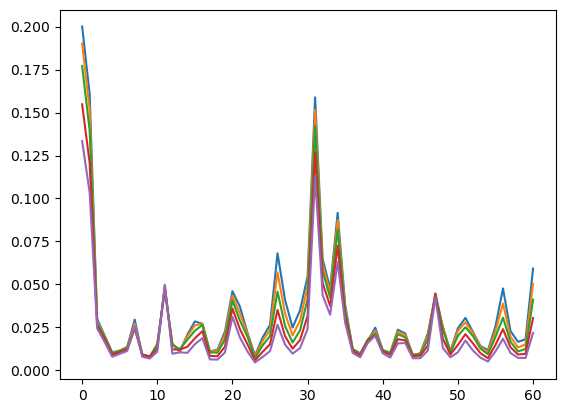

In [11]:
for i in range(5, 10):
    plt.plot(x[:, i], label='real')
plt.show()

*Observation 1*: The discriminator works really fine in telling the generated from real data apart. However, the generator does not produce realistics data (it might make the job easy for the discriminator).

*Observation 2*: From the amplitude of the wavelets, plotted across 61 channels we can see that there is definetly a problem with these values. They are completely out of range, so maybe the mere normaliation might help. Also the EEG data might need some steps to be preprocessed, such as filtering, or removing the artifacts.

**Next Steps:**

- As the first step, I made my data much simpler: instead of having 61 channels or so I only included the power spectrum from 2 channels.

- or a timeseries data, but all the samples would be the same.

- Second step would be extracting time-frequency data, instead of only having the power of each frequency bin. In this case, I'd like to see if the model can generate the sinusoidal waves with different frequencies and amplitudes.

- Next step would be changing the architecture of the generator and discriminator, for example adding more layers, and leveraging the power of the convolutional neural networks, batch normalizations and residual connections for the generator.

- In the end, I'd train a convolusional GAN which impose a more complex task to the discriminator to solve.

## Conditional GAN